## Training a Model from Scratch - Take two as per aarohi

In [2]:
# import the libraries
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [3]:
device = "cpu"

In [4]:
# setup directory paths to train and test images
train_dir = "ViT-sample/train"
test_dir = "ViT-sample/test"

## Create Datasets and Dataloaders
- load the data and we can use it

In [10]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

# create data loaders data types
def create_dataloaders(
  train_dir: str,
  test_dir: str,
  transform: transforms.Compose,
  batch_size: int,
  num_workers: int = NUM_WORKERS,  
):
    
    # use imagefolder to create datasets(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)
    
    # get class names 
    class_names = train_data.classes
    
    # turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size = batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    
    test_dataloader = DataLoader(
        test_data,
        batch_size = batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    
    return train_dataloader, test_dataloader, class_names
    

In [8]:
# create the image size - resize the images to 224x224 then convert to tensors
IMG_SIZE = 224

# create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"Manually created transforms: {manual_transforms}")


Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [12]:
# set the batch size
BATCH_SIZE = 32

# create dataloaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1b3fa7af2c0>,
 ['daisy', 'dandelion'])

torch.Size([3, 224, 224]) tensor(0)


(-0.5, 223.5, 223.5, -0.5)

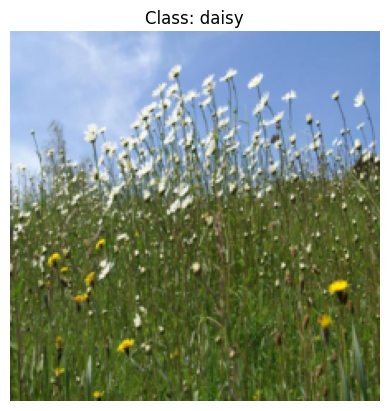

In [14]:
# let's visualize an image in order to know if data is loaded properly or not

# get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# get a single image from the batch
image, label = image_batch[0], label_batch[0]

# view the batch shapes
print(image.shape, label)

# plot with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange the dimensions suitable for matplotlib [color, height, width] -> [height, width, color]
plt.title(f"Class: {class_names[label]}")
plt.axis("off")

## Step 1

**Tasks:**

1. Turn an image into patches
2. Flatten the patch feature maps into a single dimension (1d)
3. Convert the output into Desired (flattened 2D patches): (196, 768) -> Nx(P2*C) # current shape is (1, 768, 196)
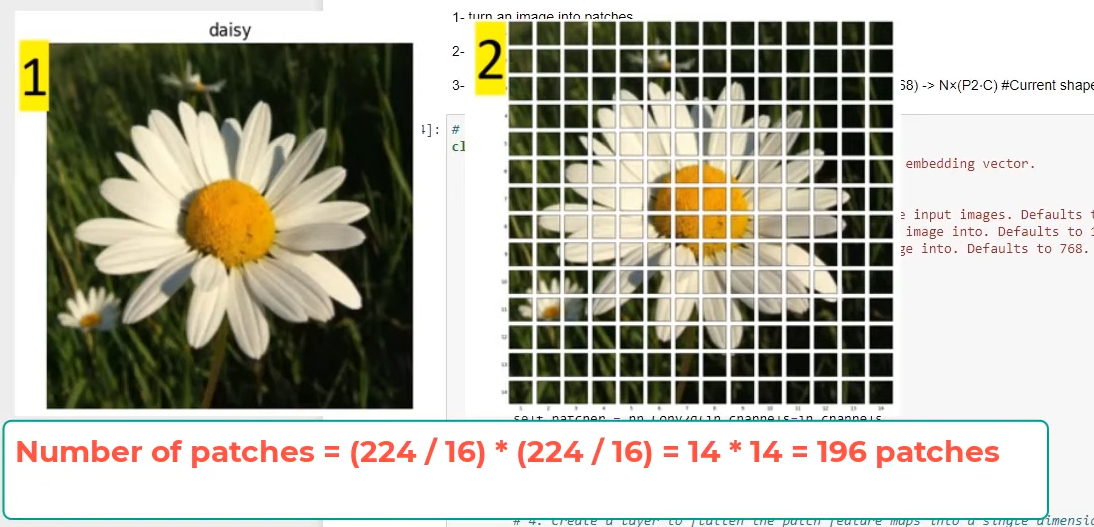

In [15]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence of learnable embedding vector.

    Args:
        in_channels (int): Number of input channels defaults into three.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768. (ex 16x16 per patch then *16 again for color dim = 768) 
    """
    # 2. Initialize the class with appropriate variables. 
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        # 3. Create a layer top turn an image into patches, patch and filter map is almost the same thing
        # feature map size is 16x16
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        
        # 4.Create a layer to flatten the patchff eature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
    # 5. Define the forward method, converts the format of the patch embedding for further process
    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be visible by patch size, image shape: {image_resolution}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        
        # 6. Make sure the output shape has the right order.
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P*2, N] -> [batch, num_patches, embedding_dim]

## PatchEmbedding layer ready

In [16]:
# let's test it on a single single image
patch_size = 16

# set seeds
def set_seeds(seed:int=42):
    """Sets random sets for torch operations

    Args:
        seed (int, optional): _description_. Defaults to 42.
    """
    # Set the seed for general operations
    torch.manual_seed(seed)
    # Set the seed for cudnn backend (ones that require GPU)
    torch.cuda.manual_seed_all(seed)

set_seeds()

patchify = PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)

print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise it will throw an error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [17]:
# View the patch embedding and patch embedding shape

print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch, num_patches, embedding_dim]")

tensor([[[-0.8039,  0.2473, -0.2590,  ...,  0.6528, -0.3389,  0.2653],
         [-0.8119,  0.2531, -0.2502,  ...,  0.6651, -0.3565,  0.2467],
         [-0.8618,  0.2311, -0.2499,  ...,  0.6852, -0.3537,  0.2760],
         ...,
         [-0.2141,  0.0943, -0.1422,  ...,  0.1754, -0.1840,  0.1406],
         [-0.3306,  0.0982, -0.0934,  ...,  0.2528, -0.1336,  0.0009],
         [-0.2973,  0.0488, -0.1867,  ...,  0.2616, -0.1046,  0.1554]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch, num_patches, embedding_dim]


In [18]:
## Now add the learnable class and position embeddings
# from start to positional encoding all in 1 cell
set_seeds()

# 1. set patch size
patch_size = 16

# 2. print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3, patch_size=patch_size, embedding_dim=768)


# 5. pass image through the embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. create a class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True) # make sure it's learnable
print(f"Class token shape: {class_token.shape}")


# 7. concatenate the class token to the patch embedding
patch_embedding_class_token = torch.cat([class_token, patch_embedding], dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. create positional embeddings
number_of_patches = int((height * width) / (patch_size ** 2))
position_embeddings = nn.Parameter(torch.ones(1, number_of_patches + 1, embedding_dimension), requires_grad=True)

# 9. add the position embeddings to the patch embeddings
patch_and_position_embeddings = patch_embedding_class_token + position_embeddings
print(f"Patch and position embeddings shape: {patch_and_position_embeddings.shape}")


print(patch_embedding_class_token)


Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embeddings shape: torch.Size([1, 197, 768])
tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [-8.0389e-01,  2.4731e-01, -2.5899e-01,  ...,  6.5279e-01,
          -3.3891e-01,  2.6534e-01],
         [-8.1186e-01,  2.5313e-01, -2.5021e-01,  ...,  6.6506e-01,
          -3.5650e-01,  2.4672e-01],
         ...,
         [-2.1410e-01,  9.4334e-02, -1.4221e-01,  ...,  1.7539e-01,
          -1.8396e-01,  1.4059e-01],
         [-3.3060e-01,  9.8212e-02, -9.3390e-02,  ...,  2.5275e-01,
          -1.3364e-01,  8.8838e-04],
         [-2.9727e-01,  4.8778e-02, -1.8674e-01,  ...,  2.6155e-01,
          -1.0461e-01,  1.5543e-01]]], grad_fn=<CatBackwa

## Let's create layers used in Transformer's encoder:

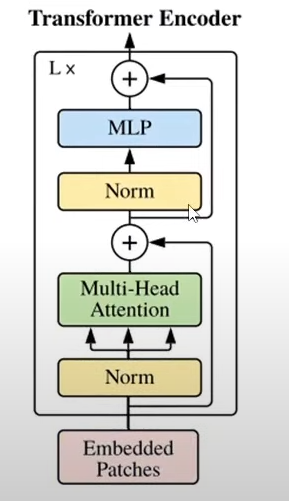

**Norm (LN or Layer Norm) - torch.nn.LayerNorm()**

Layer Normalization (torch.nn.LayerNorm()) or Norm or LayerNorm or LN normalizes an input over the last dimension.

Layer Normalization helps improve training time and model generalization (ability to adapt unseen data)

**We can implement the MSA layer in PyTorch with torch.nn.MultiheadAttention() with the parameters**

Multi-Head Self Attention (MSA) - torch.nn.MultiheadAttention()
    embed_dim - the embedding dimension D.
    num_heads - how many attention heads to use (this is where the term "multihead" comes from)
    dropout - whether or not to apply dropout to the attention layer.
    batch_first - does our batch dimension come first? (yes it does )

In [30]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block.(MSA block for short)
    """
    
    # 2. Initialize the class with hyperparameters from table 1
    def __init__(self,
                 embeding_dim:int=768, # hidden size D from the Table 1 for ViT-Base
                 num_heads:int=12, # heads from table 1 fro ViT-Base
                 attn_dropout:float=0): # doesn't llok like the paper uses any dropout in MSABlocks
        super().__init__()
        
        # 3 Create the Norm Layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embeding_dim)
        
        # 4. Create the Multihead Attention Layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embeding_dim, 
                                                    num_heads=num_heads, 
                                                    dropout=attn_dropout, 
                                                    batch_first=True) # does our batch dimension come first?
        
    # 5. Create a forward() method to pass the data through the layers.
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                                key=x, # key embeddings
                                                value=x, # value embeddings
                                                need_weights=False) 
        return attn_output
        

## MLP Block

In [34]:
#1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multi-layer perceptron block for short
    """
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.1):
        super().__init__()
        
        # 3. Create a Norm Layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multilayer preceptron MLP Layers
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity section (3.1)"
            nn.Linear(in_features=mlp_size, # needs to take the same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to the embedding_dim
            nn.Dropout(p=dropout) # dropout, when used is applied every dense layer
        )
        
    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

### Creating a transformer encoder by combing our custom made layers.

In [32]:
# 1. Create a class that inherits from nn.Module

class TransformerEncoderBlock(nn.Module):
    """Creates a transformer encoder block
    """
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()
        
        # 3. Create the Multihead Self Attention Block MSA
        self.msa_block = MultiheadSelfAttentionBlock(embeding_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    attn_dropout=attn_dropout)
        
        # 4. Create the MLP Block
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                 mlp_size=mlp_size,
                                 dropout=mlp_dropout)
    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        
        # 6. Create a residual connection for MSA block (add the input to the block)
        x = self.msa_block(x) + x
        
        # 7. Create a residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x
        
        return x

In [35]:
# Transformer Block Created

transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary
# print an input and output summary of our transformer encoder (uncomment for full output)
summary(model=transformer_encoder_block, 
        input_size=(1,197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

## Let's build a vision transformer

In [58]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!
        
        # 3. Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    # 11. Create a forward() method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1) 
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x    

### Train Model

In [59]:
vit = ViT(num_classes=len(class_names))

In [60]:
import engine

#setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # base lr from table 3 for ViT-Base
                             betas=(0.9, 0.999), # default values also mentioned in ViT paper section 4.1 (training and fine-tuning)
                             weight_decay=0.3) # from the ViT paper sectiion 4.1 (training and fine-tuning) and table 3 for ViT-Base

# setup the loss function
loss_fn = nn.CrossEntropyLoss()

# set the seeds
set_seeds()

# train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.4372 | train_acc: 0.5072 | test_loss: 0.6935 | test_acc: 0.4010
Epoch: 2 | train_loss: 0.7092 | train_acc: 0.4976 | test_loss: 0.9279 | test_acc: 0.4010
Epoch: 3 | train_loss: 0.7170 | train_acc: 0.5264 | test_loss: 0.6734 | test_acc: 0.5990
Epoch: 4 | train_loss: 0.7201 | train_acc: 0.4880 | test_loss: 0.6767 | test_acc: 0.5990
Epoch: 5 | train_loss: 0.7030 | train_acc: 0.4880 | test_loss: 0.8122 | test_acc: 0.4010
Epoch: 6 | train_loss: 0.7233 | train_acc: 0.4952 | test_loss: 0.7161 | test_acc: 0.4010
Epoch: 7 | train_loss: 0.7112 | train_acc: 0.4976 | test_loss: 0.7029 | test_acc: 0.4010
Epoch: 8 | train_loss: 0.7033 | train_acc: 0.4904 | test_loss: 0.6867 | test_acc: 0.5990
Epoch: 9 | train_loss: 0.7352 | train_acc: 0.5096 | test_loss: 0.6740 | test_acc: 0.5990
Epoch: 10 | train_loss: 0.7595 | train_acc: 0.4543 | test_loss: 0.6757 | test_acc: 0.5990


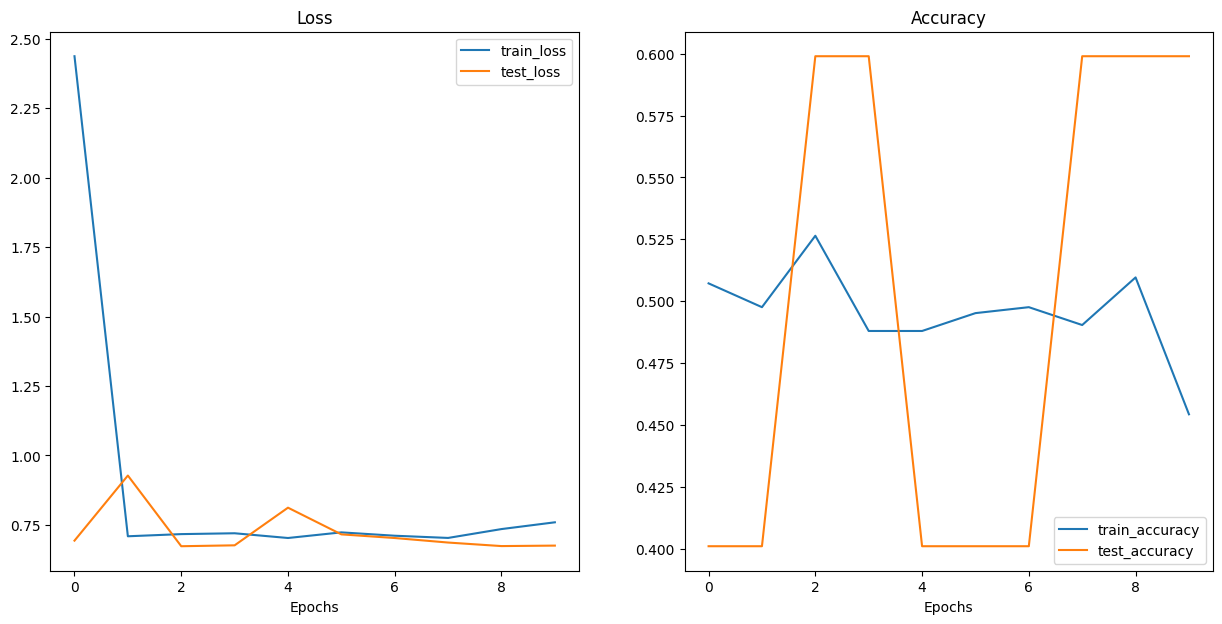

In [61]:
# To check out our ViT model's loss curves, we can use plot_loss_curves function from helper_functions.py
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## Predictions

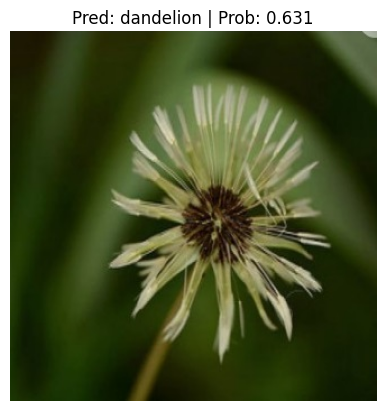

In [63]:
import requests

# Import function to make predictions on images and plot them
from predictions import pred_and_plot_image

custom_image_path = "test_img.jpg"

# predict on custom`image`
pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names)